# Introduction

In this notebook, we will build a neural network that takes in two MNIST digits on separate planes and attempts to distinguish whether they represent the same image or not. Let's begin with necessary imports.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import torchvision
from torchvision.datasets import MNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.figure import Figure, SubFigure
from matplotlib.axes import Axes
from time import time
from tqdm import tqdm
from math import ceil

# Loading in the Dataset

Let's begin by loading in the MNIST dataset as `torch.Tensor`s. We will be saving the train and test sets separately and processing them separately too.

In [2]:
train_MNIST: MNIST = MNIST(
    './MNIST/',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_MNIST: MNIST = MNIST(
    './MNIST/',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_MNIST_tensor: torch.Tensor = train_MNIST.data.to(torch.float32)
train_MNIST_labels: torch.Tensor = train_MNIST.targets
test_MNIST_tensor: torch.Tensor = test_MNIST.data.to(torch.float32)
test_MNIST_labels: torch.Tensor = test_MNIST.targets

For this task, we will only be making use of $10\%$ of our train and test sets. These smaller sets will have more than enough data for our task as we will be assigning data points together to form a much larger dataset.

In [4]:
def random_subset(
    x: torch.Tensor,
    y: torch.Tensor,
    fraction: float
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Gets a random subset of the dataset without conversion to a Subset object.
    Sorts the indices such as to receive data points in the same order as the
    original Tensor. Takes a balanced number of samples of each class.
    Assumes x and y are indexed identically and that both the fraction and
    number of labels together divide cleanly into the number of samples (and
    that there are at least this many samples of each class).

    Parameters:
        x:          The input for the dataset
        y:          The target for the dataset
        fraction:   The fraction of the data to be taken as a random subset

    Returns:
        The generated subset of the dataset.
    """
    label: int
    labels: list[int] = [digit.item() for digit in y.unique()]
    samples_of_each_label: int = int(x.size(0) * fraction) // len(labels)
    indices: torch.Tensor = torch.IntTensor()
    for label in labels:
        label_indices: torch.Tensor = torch.nonzero(
            y == label
        ).flatten()
        subset_label_indices: torch.Tensor = torch.randperm(
            label_indices.size(0)
        )[:samples_of_each_label]
        indices = torch.cat((indices, label_indices[subset_label_indices]))
    indices = indices.sort()[0]

    return x[indices], y[indices]

In [5]:
data_fraction: float = 0.1
train_MNIST_spliced: torch.Tensor; train_MNIST_labels_spliced: torch.Tensor 
train_MNIST_spliced, train_MNIST_labels_spliced = random_subset(
    train_MNIST_tensor,
    train_MNIST_labels,
    data_fraction
)
test_MNIST_spliced: torch.Tensor; test_MNIST_labels_spliced: torch.Tensor 
test_MNIST_spliced, test_MNIST_labels_spliced = random_subset(
    test_MNIST_tensor,
    test_MNIST_labels,
    data_fraction
)

Now let's print some representative samples from MNIST.

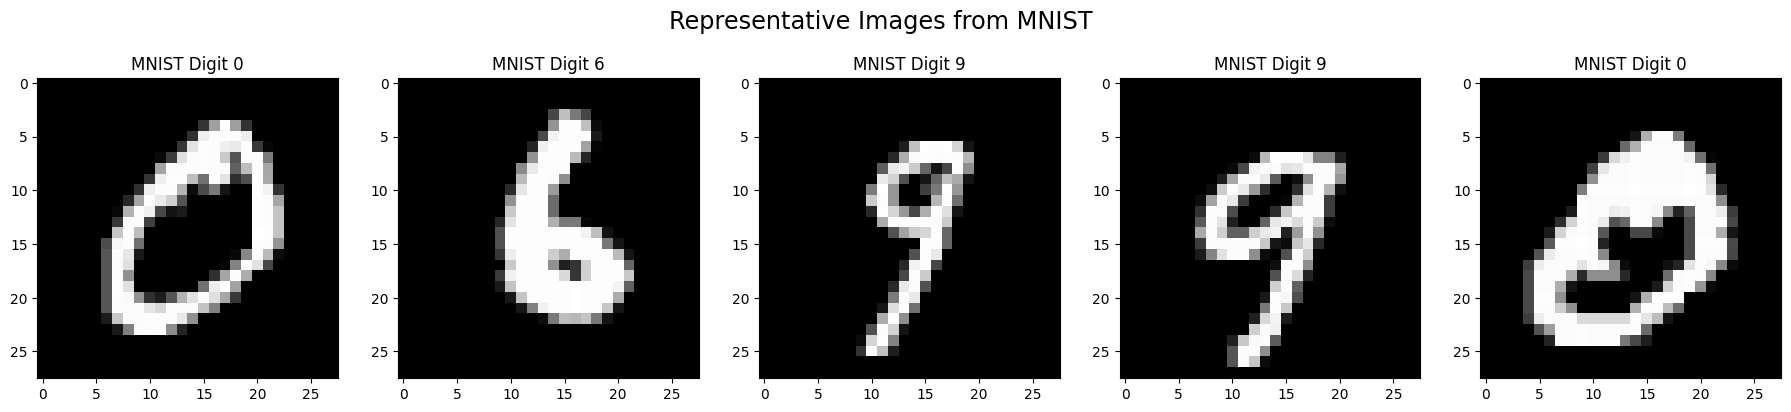

In [6]:
num_reps: int = 5

rep_fig: Figure; rep_axs: np.ndarray
rep_fig, rep_axs = plt.subplots(1, num_reps)
rep_fig.set_figwidth(4.5 * num_reps)
rep_fig.set_figheight(4.5)
rep_fig.suptitle('Representative Images from MNIST', size='xx-large')
for i in range(num_reps):
    axs: Axes = rep_axs[i]
    axs.imshow(train_MNIST_spliced[i].squeeze().numpy(), cmap='gray')
    axs.set_title(f'MNIST Digit {train_MNIST_labels_spliced[i]}')
plt.show()

Preparing this data for our classification task will be rather tedious. Why? Well, we could pick a naive approach and randomly group MNIST digits together until we have enough data points, but this would result in a heavily imbalanced dataset. If we pick any two MNIST data points $(x, y)_i$ and $(x, y)_j$, then we have that
$$\mathbb{P}[y_i = y_j] = \frac{1}{10}$$
That is, since there are ten classes in the dataset, the two data points only have a one in ten chance of being the same digit (this probability is exact since we've taken a balanced subset of the dataset). This means that our naive algorithm will result in only one-tenth of the dataset having a label of $1$, and the model would be incentivized to pick $0$ more often (in fact, always guessing $0$ would yield the model $90\%$ accuracy). This may not necessarily be the worst outcome, especially if we expect our model to see many more points with different samples in the future, but let's strive for a more well-rounded model.

Let's take care to ensure that our dataset is balanced, with exactly $50\%$ of the samples having either label. To do this, we'll build the samples with the same image separately from the samples with different images. We will generate $100000$ training data points and $20000$ test data points.

First, let's split up our dataset by MNIST label. Then, to build samples with the same digit on both planes, we'll randomly group together these elements with the same label. To build samples with different digits on both planes, we'll need to do something a bit more subtle. We want to make sure the model sees enough samples of each combination of digits so that it's not particularly weak to, for example $8$ on the first plane and $1$ on the second plane. For that reason, we'll iterate through every combination of labels and randomly group together data points with that specific combination of labels in that order. After we've sourced samples with both the same and different digits, we'll combine together those two groups to get our final dataset!

In [7]:
def get_dataset(
    x: torch.Tensor,
    y: torch.Tensor,
    final_size: int
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Given an original dataset with many classes, creates a dataset such that two
    samples from said dataset are on separate planes. 50% of the samples will
    have the same class on both planes (and have label 1), and the other 50%
    will have different classes, where the ratios of the respective classes are
    balanced. Assumes the input datasets are perfectly balanced between their
    classes.
    
    Parameters:
        x:          The input variables for the dataset
        y:          The target variables for the dataset
        final_size: The desired final size for the dataset
    
    Returns:
        The generated dataset with two classes.
    """
    num_classes: int = torch.unique(y).size(0)
    indices_of_each_label: list[torch.Tensor] = [
        torch.nonzero(
            y == label
        ).flatten()
        for label in range(num_classes)
    ]
    label_one: torch.Tensor = get_same_digit(
        x,
        indices_of_each_label,
        num_classes,
        final_size // 2
    )
    label_zero: torch.Tensor = get_different_digit(
        x,
        indices_of_each_label,
        num_classes,
        final_size // 2
    )
    x_final: torch.Tensor = torch.cat([label_zero, label_one])
    y_final: torch.Tensor = torch.tensor(
        [0] * label_zero.size(0) + [1] * label_one.size(0)
    ).to(torch.float32)
    return x_final, y_final

def get_same_digit(
    x: torch.Tensor,
    indices_of_each_label: torch.Tensor,
    num_classes: int,
    final_size: int,
) -> torch.Tensor:
    """
    Randomly assigns samples of the same label to each other and puts them on 
    different planes of a sample. Creates final_size samples.

    Parameters:
        x:                      The input variables for the dataset
        indices_of_each_label:  A list of tensors, each containing the indices
                                in x that correspond to samples of each label
        num_classes:            The number of classes in x
        final_size:             The desired final size of the dataset

    Returns:
        Samples of the dataset with the same digit on both planes
    """
    final_samples_per_class: int =  final_size // num_classes
    orig_samples_per_class: int = indices_of_each_label[0].size(0)
    iterations: int = ceil(final_samples_per_class * 2 / orig_samples_per_class)
    same_labels: list[torch.Tensor] = []
    for label in range(num_classes):
        indices: torch.Tensor = indices_of_each_label[label]
        for _ in range(iterations):
            permutation: torch.Tensor = torch.randperm(indices.size(0))
            permuted_train: torch.Tensor = indices[permutation]
            same_labels.append(
                permuted_train.reshape(
                    (int(permuted_train.size(0) / 2), 2)
                )
            )
    same_label_tensor: torch.Tensor = torch.cat(same_labels)[:final_size, :]
    return torch.stack([
        x[same_label_tensor[:, 0]],
        x[same_label_tensor[:, 1]]
    ], dim=1)

def get_different_digit(
    x: torch.Tensor,
    indices_of_each_label: torch.Tensor,
    num_classes: torch.Tensor,
    final_size: int,
) -> torch.Tensor:
    """
    Randomly assigns a balanced set of differently labeled samples to each other
    and puts them on different planes of a sample. Creates final_size samples.

    Parameters:
        x:                      The input variables for the dataset
        indices_of_each_label:  A list of tensors, each containing the indices
                                in x that correspond to samples of each label
        num_classes:            The number of classes in x
        final_size:             The desired final size of the dataset

    Returns:
        Samples of the dataset with different digits on both planes
    """
    final_samples_per_class: int = final_size // num_classes
    orig_samples_per_class: int = indices_of_each_label[0].size(0)
    iterations = ceil(
        final_samples_per_class / ((num_classes - 1) * orig_samples_per_class)
    )
    diff_labels: list[torch.Tensor] = []
    for label in range(num_classes):
        indices: torch.Tensor = indices_of_each_label[label]
        for other_label in range(num_classes):
            if label == other_label: continue
            for _ in range(iterations):
                other_indices: torch.Tensor = indices_of_each_label[other_label]

                permutation: torch.Tensor = torch.randperm(
                    indices.size(0)
                )
                other_permutation: torch.Tensor = torch.randperm(
                    other_indices.size(0)
                )
                perm_ind: torch.Tensor = indices[permutation]
                other_perm_ind: torch.Tensor = other_indices[other_permutation]
                stacked_indices: torch.Tensor = torch.stack(
                    [
                        perm_ind,
                        other_perm_ind
                    ]
                )
                diff_labels.append(stacked_indices.T)
    diff_labels_tensor: torch.Tensor = torch.cat(diff_labels)
    sorted_indices: torch.Tensor = torch.randperm(
        diff_labels_tensor.size(0)
    )[:final_size].sort()[0]
    diff_labels_subsampled: torch.Tensor = diff_labels_tensor.index_select(
        0,
        sorted_indices
    )
    return torch.stack([
        x[diff_labels_subsampled[:, 0]],
        x[diff_labels_subsampled[:, 1]]
    ], dim=1)

In [8]:
train_data_size: int = 100000
test_data_size: int = 20000
train_x: torch.Tensor; train_y: torch.Tensor
test_x: torch.Tensor; test_y: torch.Tensor
train_x, train_y = get_dataset(
    train_MNIST_spliced,
    train_MNIST_labels_spliced,
    train_data_size
)
test_x, test_y = get_dataset(
    test_MNIST_spliced,
    test_MNIST_labels_spliced,
    test_data_size
)

Now let's put our data into `DataLoader`s so we can visualize some random samples! We will use a batch size of $64$ and randomly shuffle our train set to induce stochasticity in training. We do not need to shuffle our test set as we will always evalute over the whole test set at once.

In [9]:
train_set: TensorDataset = TensorDataset(train_x, train_y)
test_set: TensorDataset = TensorDataset(test_x, test_y)

In [10]:
train_dataloader: DataLoader = DataLoader(
    train_set,
    batch_size=64,
    shuffle=True
)
test_dataloader: DataLoader = DataLoader(
    test_set,
    batch_size=64,
    shuffle=False
)

Here are some random samples. If you're running this on your own and samples of only one class come up, feel free keep rerunning the above cell to reshuffle the data until you get samples of different classes below, if you'd like to see representatives for both classes.

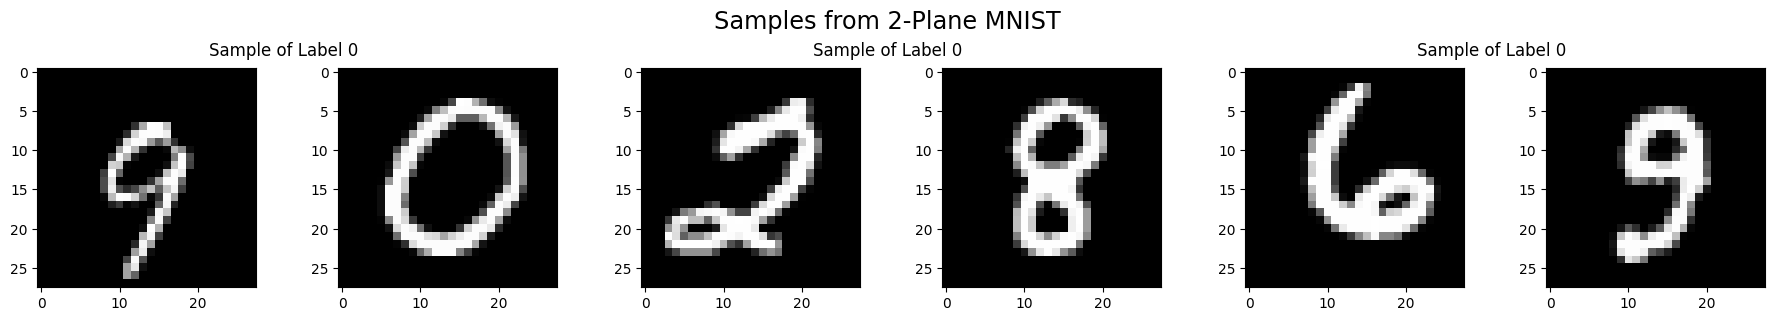

In [11]:
num_reps: int = 3
images: torch.Tensor; labels: torch.Tensor
images, labels = next(iter(train_dataloader))

fig: Figure = plt.figure(layout='compressed', figsize=(18, 3))
reps_subfigs: np.ndarray = fig.subfigures(1, num_reps)
for i in range(num_reps):
    subfig: SubFigure = reps_subfigs[i]
    axs: np.ndarray = subfig.subplots(1, 2)
    image: torch.Tensor = images[i]
    label: torch.Tensor = labels[i]
    subfig.suptitle(f'Sample of Label {int(label)}')
    ax: Axes
    for i in range(axs.shape[0]):
        ax = axs[i]
        ax.imshow(image[i].squeeze().numpy(), cmap='gray')
fig.suptitle('Samples from 2-Plane MNIST', size='xx-large')
plt.show()

# Building the Classifier

Now let's finally build the model! Our classifier will take in an input of size $2 \times 28 \times 28$ (ignoring the batch size). Here is a diagram of the full architecture:
<p align="center">
    <img src="./classifier_diagram.png" height=500px>
</p> 

The classifier will have a learning rate of $0.0001$ and will train for $100$ epochs with the `torch.optim.Adam` optimizer. It will use $\ell_2$ regularization with a parameter of $\lambda=0.001$. It will use the ``torch.nn.BCELoss`` loss function, which, for a single training example $(x, y)$, is defined as $$\mathcal{L}(\theta) = -y\log f(x;\theta) - (1 - y)\log(1 - f(x;\theta))$$
where $f$ is our model, parameterized by $\theta$.

In [12]:
class Two_Plane_MNIST_ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1: nn.Conv2d = nn.Conv2d(
            in_channels=2,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding=(1, 1)
        )
        self.bn1: nn.BatchNorm2d = nn.BatchNorm2d(num_features=32)
        self.dropout1: nn.Dropout2d = nn.Dropout2d(p=0.3)
        self.pool1: nn.MaxPool2d = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2: nn.Conv2d = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding=(1, 1)
        )
        self.bn2: nn.BatchNorm2d = nn.BatchNorm2d(num_features=64)
        self.dropout2: nn.Dropout2d = nn.Dropout2d(p=0.3)

        self.linear1: nn.Linear = nn.Linear(1024, 128)
        self.dropout3: nn.Dropout = nn.Dropout(p=0.4)

        self.linear2: nn.Linear = nn.Linear(128, 16)
        self.dropout4: nn.Dropout = nn.Dropout(p=0.4)

        self.linear3: nn.Linear = nn.Linear(16, 1)

        self.relu: nn.ReLU = nn.ReLU()
        self.leaky_relu: nn.LeakyReLU = nn.LeakyReLU()
        self.sigmoid: nn.Sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.bn1(self.conv1(x))
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.pool1(x)

        x = self.bn2(self.conv2(x))
        x = self.relu(x)
        x = self.dropout2(x)

        x = x.view(-1, 1024)
        
        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.dropout3(x)

        x = self.linear2(x)
        x = self.leaky_relu(x)
        x = self.dropout4(x)

        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [13]:
lr: float = 0.0001
epochs: int = 100

model: Two_Plane_MNIST_ConvNet = Two_Plane_MNIST_ConvNet().cuda()
loss: nn.BCELoss = nn.BCELoss()
optimizer: Adam = Adam(model.parameters(), lr=lr, weight_decay=0.001)

Let's take a look at our model.

In [14]:
model

Two_Plane_MNIST_ConvNet(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=128, out_features=16, bias=True)
  (dropout4): Dropout(p=0.4, inplace=False)
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

# Training the Model

Now let's train the model. At the end of every epoch, we will record the average train loss over all batches in the epoch, as well as the test loss, and print those values out along with the time elapsed.

In [15]:
metrics: list[str] = ['Train Loss', 'Test Loss']
history: pd.DataFrame = pd.DataFrame(columns=metrics)

for epoch in range(epochs):
    train_loss: float = 0.0
    test_loss: float = 0.0
    start_time: float = time()
    x: torch.Tensor; y: torch.Tensor
    print(f'Epoch {epoch + 1}')
    print('Training...')
    model.train()
    for _, (x, y) in enumerate(tqdm(train_dataloader)):
        x = x.cuda()
        y = y.unsqueeze(1).cuda()
        optimizer.zero_grad()
        y_pred: torch.Tensor = model(x)
        fit: torch.Tensor = loss(y_pred, y)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
    train_loss /= len(train_dataloader)
    print(f'Train Loss: {train_loss}')
    print('Testing...')
    model.eval()
    for _, (x, y) in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            y_pred = model(x)
            fit = loss(y_pred, y)
            test_loss += fit.item()
    test_loss /= len(test_dataloader)
    history.loc[len(history)] = [train_loss, test_loss]
    time_elapsed: float = time() - start_time
    print(f'Test Loss: {test_loss}')
    print(f'Time Elapsed: {time_elapsed:.2f}s')

Epoch 1
Training...


  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:11<00:00, 140.40it/s]


Train Loss: 0.6415514575885949
Testing...


100%|██████████| 313/313 [00:00<00:00, 356.92it/s]


Test Loss: 0.5213802669185419
Time Elapsed: 12.03s
Epoch 2
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.68it/s]


Train Loss: 0.5222138409918116
Testing...


100%|██████████| 313/313 [00:00<00:00, 405.35it/s]


Test Loss: 0.4432075549238406
Time Elapsed: 10.90s
Epoch 3
Training...


100%|██████████| 1563/1563 [00:10<00:00, 151.16it/s]


Train Loss: 0.467575680052174
Testing...


100%|██████████| 313/313 [00:00<00:00, 462.49it/s]


Test Loss: 0.3965414640621636
Time Elapsed: 11.02s
Epoch 4
Training...


100%|██████████| 1563/1563 [00:09<00:00, 163.53it/s]


Train Loss: 0.43256971995112076
Testing...


100%|██████████| 313/313 [00:00<00:00, 443.28it/s]


Test Loss: 0.373654461617525
Time Elapsed: 10.27s
Epoch 5
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.44it/s]


Train Loss: 0.40980123647954014
Testing...


100%|██████████| 313/313 [00:00<00:00, 441.90it/s]


Test Loss: 0.3392012407794928
Time Elapsed: 10.58s
Epoch 6
Training...


100%|██████████| 1563/1563 [00:09<00:00, 159.80it/s]


Train Loss: 0.3871341720557106
Testing...


100%|██████████| 313/313 [00:00<00:00, 395.44it/s]


Test Loss: 0.33126491517685475
Time Elapsed: 10.58s
Epoch 7
Training...


100%|██████████| 1563/1563 [00:09<00:00, 160.82it/s]


Train Loss: 0.3703847341501629
Testing...


100%|██████████| 313/313 [00:00<00:00, 482.07it/s]


Test Loss: 0.30921615319796647
Time Elapsed: 10.37s
Epoch 8
Training...


100%|██████████| 1563/1563 [00:09<00:00, 159.06it/s]


Train Loss: 0.3558844719952067
Testing...


100%|██████████| 313/313 [00:00<00:00, 458.14it/s]


Test Loss: 0.2922848089993857
Time Elapsed: 10.52s
Epoch 9
Training...


100%|██████████| 1563/1563 [00:09<00:00, 167.51it/s]


Train Loss: 0.34360440905782097
Testing...


100%|██████████| 313/313 [00:00<00:00, 482.17it/s]


Test Loss: 0.2817987299586733
Time Elapsed: 9.99s
Epoch 10
Training...


100%|██████████| 1563/1563 [00:09<00:00, 169.49it/s]


Train Loss: 0.3311848893942775
Testing...


100%|██████████| 313/313 [00:00<00:00, 494.40it/s]


Test Loss: 0.2668546304945795
Time Elapsed: 9.86s
Epoch 11
Training...


100%|██████████| 1563/1563 [00:09<00:00, 167.31it/s]


Train Loss: 0.32269687478693343
Testing...


100%|██████████| 313/313 [00:00<00:00, 490.57it/s]


Test Loss: 0.25841245928202006
Time Elapsed: 9.99s
Epoch 12
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.93it/s]


Train Loss: 0.309579599603429
Testing...


100%|██████████| 313/313 [00:00<00:00, 447.76it/s]


Test Loss: 0.2438924404474112
Time Elapsed: 10.55s
Epoch 13
Training...


100%|██████████| 1563/1563 [00:10<00:00, 146.20it/s]


Train Loss: 0.30233189988921866
Testing...


100%|██████████| 313/313 [00:00<00:00, 437.73it/s]


Test Loss: 0.23927279889654998
Time Elapsed: 11.41s
Epoch 14
Training...


100%|██████████| 1563/1563 [00:10<00:00, 146.99it/s]


Train Loss: 0.29428946393198185
Testing...


100%|██████████| 313/313 [00:00<00:00, 352.50it/s]


Test Loss: 0.23082349607096123
Time Elapsed: 11.53s
Epoch 15
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.68it/s]


Train Loss: 0.2902361481752597
Testing...


100%|██████████| 313/313 [00:00<00:00, 404.79it/s]


Test Loss: 0.22252964917213297
Time Elapsed: 10.63s
Epoch 16
Training...


100%|██████████| 1563/1563 [00:09<00:00, 163.32it/s]


Train Loss: 0.2825333640856462
Testing...


100%|██████████| 313/313 [00:00<00:00, 427.41it/s]


Test Loss: 0.2177457234081321
Time Elapsed: 10.31s
Epoch 17
Training...


100%|██████████| 1563/1563 [00:09<00:00, 165.29it/s]


Train Loss: 0.2756496916309962
Testing...


100%|██████████| 313/313 [00:00<00:00, 406.51it/s]


Test Loss: 0.2139389024981961
Time Elapsed: 10.23s
Epoch 18
Training...


100%|██████████| 1563/1563 [00:10<00:00, 153.44it/s]


Train Loss: 0.2696763261752257
Testing...


100%|██████████| 313/313 [00:00<00:00, 450.60it/s]


Test Loss: 0.20897774823968068
Time Elapsed: 10.89s
Epoch 19
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.72it/s]


Train Loss: 0.26490796198657285
Testing...


100%|██████████| 313/313 [00:00<00:00, 436.70it/s]


Test Loss: 0.20508021805673457
Time Elapsed: 10.82s
Epoch 20
Training...


100%|██████████| 1563/1563 [00:09<00:00, 157.39it/s]


Train Loss: 0.2587773046114852
Testing...


100%|██████████| 313/313 [00:00<00:00, 394.41it/s]


Test Loss: 0.19314448188502378
Time Elapsed: 10.73s
Epoch 21
Training...


100%|██████████| 1563/1563 [00:11<00:00, 137.73it/s]


Train Loss: 0.25306059237538586
Testing...


100%|██████████| 313/313 [00:00<00:00, 334.54it/s]


Test Loss: 0.19164673095277418
Time Elapsed: 12.29s
Epoch 22
Training...


100%|██████████| 1563/1563 [00:11<00:00, 139.16it/s]


Train Loss: 0.24925169354913637
Testing...


100%|██████████| 313/313 [00:00<00:00, 430.44it/s]


Test Loss: 0.18551779635988486
Time Elapsed: 11.97s
Epoch 23
Training...


100%|██████████| 1563/1563 [00:10<00:00, 149.35it/s]


Train Loss: 0.24481574245755366
Testing...


100%|██████████| 313/313 [00:00<00:00, 432.98it/s]


Test Loss: 0.1796775094409006
Time Elapsed: 11.20s
Epoch 24
Training...


100%|██████████| 1563/1563 [00:09<00:00, 156.72it/s]


Train Loss: 0.24193063794956401
Testing...


100%|██████████| 313/313 [00:00<00:00, 409.35it/s]


Test Loss: 0.18046400988825595
Time Elapsed: 10.75s
Epoch 25
Training...


100%|██████████| 1563/1563 [00:09<00:00, 162.91it/s]


Train Loss: 0.23824423051517282
Testing...


100%|██████████| 313/313 [00:00<00:00, 438.36it/s]


Test Loss: 0.17449435966160778
Time Elapsed: 10.32s
Epoch 26
Training...


100%|██████████| 1563/1563 [00:09<00:00, 157.46it/s]


Train Loss: 0.23339684470601366
Testing...


100%|██████████| 313/313 [00:00<00:00, 421.64it/s]


Test Loss: 0.16939222633231657
Time Elapsed: 10.68s
Epoch 27
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.49it/s]


Train Loss: 0.2307808775638283
Testing...


100%|██████████| 313/313 [00:00<00:00, 451.03it/s]


Test Loss: 0.17067091352344987
Time Elapsed: 10.56s
Epoch 28
Training...


100%|██████████| 1563/1563 [00:10<00:00, 156.03it/s]


Train Loss: 0.22580887764806712
Testing...


100%|██████████| 313/313 [00:00<00:00, 444.72it/s]


Test Loss: 0.16392822391517198
Time Elapsed: 10.73s
Epoch 29
Training...


100%|██████████| 1563/1563 [00:09<00:00, 159.53it/s]


Train Loss: 0.22451293594796765
Testing...


100%|██████████| 313/313 [00:00<00:00, 430.64it/s]


Test Loss: 0.1589132988135131
Time Elapsed: 10.53s
Epoch 30
Training...


100%|██████████| 1563/1563 [00:10<00:00, 155.75it/s]


Train Loss: 0.22103629737939884
Testing...


100%|██████████| 313/313 [00:00<00:00, 428.86it/s]


Test Loss: 0.15657567034234493
Time Elapsed: 10.77s
Epoch 31
Training...


100%|██████████| 1563/1563 [00:09<00:00, 156.36it/s]


Train Loss: 0.21852979579283804
Testing...


100%|██████████| 313/313 [00:00<00:00, 457.33it/s]


Test Loss: 0.1533128518176774
Time Elapsed: 10.69s
Epoch 32
Training...


100%|██████████| 1563/1563 [00:09<00:00, 169.22it/s]


Train Loss: 0.2159355447954729
Testing...


100%|██████████| 313/313 [00:00<00:00, 425.24it/s]


Test Loss: 0.1543706518303329
Time Elapsed: 9.98s
Epoch 33
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.76it/s]


Train Loss: 0.21298254475293066
Testing...


100%|██████████| 313/313 [00:00<00:00, 466.55it/s]


Test Loss: 0.14774480944026275
Time Elapsed: 10.78s
Epoch 34
Training...


100%|██████████| 1563/1563 [00:09<00:00, 162.97it/s]


Train Loss: 0.2126844859683811
Testing...


100%|██████████| 313/313 [00:00<00:00, 485.70it/s]


Test Loss: 0.1480882322778717
Time Elapsed: 10.24s
Epoch 35
Training...


100%|██████████| 1563/1563 [00:09<00:00, 161.78it/s]


Train Loss: 0.20939043938389057
Testing...


100%|██████████| 313/313 [00:00<00:00, 462.50it/s]


Test Loss: 0.14380289840559585
Time Elapsed: 10.35s
Epoch 36
Training...


100%|██████████| 1563/1563 [00:09<00:00, 159.13it/s]


Train Loss: 0.20614912592575327
Testing...


100%|██████████| 313/313 [00:00<00:00, 454.90it/s]


Test Loss: 0.13667531453739531
Time Elapsed: 10.52s
Epoch 37
Training...


100%|██████████| 1563/1563 [00:09<00:00, 161.99it/s]


Train Loss: 0.20432047485370936
Testing...


100%|██████████| 313/313 [00:00<00:00, 440.51it/s]


Test Loss: 0.14004168466042977
Time Elapsed: 10.37s
Epoch 38
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.13it/s]


Train Loss: 0.20222380077102897
Testing...


100%|██████████| 313/313 [00:00<00:00, 450.22it/s]


Test Loss: 0.13902198059555773
Time Elapsed: 10.84s
Epoch 39
Training...


100%|██████████| 1563/1563 [00:10<00:00, 149.82it/s]


Train Loss: 0.20117472819102092
Testing...


100%|██████████| 313/313 [00:00<00:00, 449.29it/s]


Test Loss: 0.13154212945325378
Time Elapsed: 11.14s
Epoch 40
Training...


100%|██████████| 1563/1563 [00:10<00:00, 151.60it/s]


Train Loss: 0.19871239383929598
Testing...


100%|██████████| 313/313 [00:00<00:00, 413.27it/s]


Test Loss: 0.13520447591754098
Time Elapsed: 11.08s
Epoch 41
Training...


100%|██████████| 1563/1563 [00:11<00:00, 136.88it/s]


Train Loss: 0.1984943776741214
Testing...


100%|██████████| 313/313 [00:00<00:00, 378.03it/s]


Test Loss: 0.1315987965638062
Time Elapsed: 12.25s
Epoch 42
Training...


100%|██████████| 1563/1563 [00:10<00:00, 152.35it/s]


Train Loss: 0.1945894191462263
Testing...


100%|██████████| 313/313 [00:00<00:00, 372.34it/s]


Test Loss: 0.13378246358711832
Time Elapsed: 11.11s
Epoch 43
Training...


100%|██████████| 1563/1563 [00:09<00:00, 160.89it/s]


Train Loss: 0.19256579000514742
Testing...


100%|██████████| 313/313 [00:00<00:00, 363.01it/s]


Test Loss: 0.12550195696028754
Time Elapsed: 10.58s
Epoch 44
Training...


100%|██████████| 1563/1563 [00:10<00:00, 156.12it/s]


Train Loss: 0.19169601925570692
Testing...


100%|██████████| 313/313 [00:00<00:00, 405.26it/s]


Test Loss: 0.1267853704885172
Time Elapsed: 10.79s
Epoch 45
Training...


100%|██████████| 1563/1563 [00:11<00:00, 138.39it/s]


Train Loss: 0.1883896013873171
Testing...


100%|██████████| 313/313 [00:00<00:00, 375.00it/s]


Test Loss: 0.12682149695387235
Time Elapsed: 12.14s
Epoch 46
Training...


100%|██████████| 1563/1563 [00:10<00:00, 151.59it/s]


Train Loss: 0.18643961166122824
Testing...


100%|██████████| 313/313 [00:00<00:00, 390.09it/s]


Test Loss: 0.12246387840483706
Time Elapsed: 11.12s
Epoch 47
Training...


100%|██████████| 1563/1563 [00:09<00:00, 164.19it/s]


Train Loss: 0.18533716038803755
Testing...


100%|██████████| 313/313 [00:00<00:00, 342.20it/s]


Test Loss: 0.1205310032564623
Time Elapsed: 10.44s
Epoch 48
Training...


100%|██████████| 1563/1563 [00:10<00:00, 151.71it/s]


Train Loss: 0.18440106148835717
Testing...


100%|██████████| 313/313 [00:00<00:00, 426.51it/s]


Test Loss: 0.11996131140914279
Time Elapsed: 11.05s
Epoch 49
Training...


100%|██████████| 1563/1563 [00:09<00:00, 161.78it/s]


Train Loss: 0.1858816932593678
Testing...


100%|██████████| 313/313 [00:00<00:00, 415.50it/s]


Test Loss: 0.11930206876111249
Time Elapsed: 10.42s
Epoch 50
Training...


100%|██████████| 1563/1563 [00:09<00:00, 163.70it/s]


Train Loss: 0.18095033345547382
Testing...


100%|██████████| 313/313 [00:00<00:00, 383.27it/s]


Test Loss: 0.11611755214595852
Time Elapsed: 10.37s
Epoch 51
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.15it/s]


Train Loss: 0.18003614632006418
Testing...


100%|██████████| 313/313 [00:00<00:00, 362.38it/s]


Test Loss: 0.11725771021597778
Time Elapsed: 11.01s
Epoch 52
Training...


100%|██████████| 1563/1563 [00:11<00:00, 138.17it/s]


Train Loss: 0.1811316956504369
Testing...


100%|██████████| 313/313 [00:00<00:00, 394.55it/s]


Test Loss: 0.11653936761111533
Time Elapsed: 12.11s
Epoch 53
Training...


100%|██████████| 1563/1563 [00:10<00:00, 151.32it/s]


Train Loss: 0.17860312856166544
Testing...


100%|██████████| 313/313 [00:00<00:00, 346.42it/s]


Test Loss: 0.11250229966945756
Time Elapsed: 11.24s
Epoch 54
Training...


100%|██████████| 1563/1563 [00:11<00:00, 139.51it/s]


Train Loss: 0.17758823384221592
Testing...


100%|██████████| 313/313 [00:00<00:00, 362.70it/s]


Test Loss: 0.1120406851022186
Time Elapsed: 12.07s
Epoch 55
Training...


100%|██████████| 1563/1563 [00:10<00:00, 145.05it/s]


Train Loss: 0.17624011079966068
Testing...


100%|██████████| 313/313 [00:00<00:00, 405.37it/s]


Test Loss: 0.11501489495174191
Time Elapsed: 11.55s
Epoch 56
Training...


100%|██████████| 1563/1563 [00:10<00:00, 155.72it/s]


Train Loss: 0.17512698805225407
Testing...


100%|██████████| 313/313 [00:00<00:00, 392.63it/s]


Test Loss: 0.10936901419789503
Time Elapsed: 10.84s
Epoch 57
Training...


100%|██████████| 1563/1563 [00:10<00:00, 155.63it/s]


Train Loss: 0.17420746343149562
Testing...


100%|██████████| 313/313 [00:00<00:00, 412.39it/s]


Test Loss: 0.10941004390551592
Time Elapsed: 10.81s
Epoch 58
Training...


100%|██████████| 1563/1563 [00:09<00:00, 159.18it/s]


Train Loss: 0.17088369863561842
Testing...


100%|██████████| 313/313 [00:00<00:00, 426.37it/s]


Test Loss: 0.10954910300719661
Time Elapsed: 10.56s
Epoch 59
Training...


100%|██████████| 1563/1563 [00:10<00:00, 155.23it/s]


Train Loss: 0.17331933405343264
Testing...


100%|██████████| 313/313 [00:00<00:00, 435.98it/s]


Test Loss: 0.1104021575755645
Time Elapsed: 10.79s
Epoch 60
Training...


100%|██████████| 1563/1563 [00:09<00:00, 168.58it/s]


Train Loss: 0.17184024035539752
Testing...


100%|██████████| 313/313 [00:00<00:00, 417.58it/s]


Test Loss: 0.1072774366007005
Time Elapsed: 10.03s
Epoch 61
Training...


100%|██████████| 1563/1563 [00:09<00:00, 156.97it/s]


Train Loss: 0.17030481895478353
Testing...


100%|██████████| 313/313 [00:00<00:00, 323.57it/s]


Test Loss: 0.10483547438608525
Time Elapsed: 10.93s
Epoch 62
Training...


100%|██████████| 1563/1563 [00:10<00:00, 151.90it/s]


Train Loss: 0.1675905547035061
Testing...


100%|██████████| 313/313 [00:00<00:00, 403.28it/s]


Test Loss: 0.10516998771661387
Time Elapsed: 11.07s
Epoch 63
Training...


100%|██████████| 1563/1563 [00:10<00:00, 155.45it/s]


Train Loss: 0.1684152334165817
Testing...


100%|██████████| 313/313 [00:00<00:00, 386.27it/s]


Test Loss: 0.10455792057313049
Time Elapsed: 10.87s
Epoch 64
Training...


100%|██████████| 1563/1563 [00:10<00:00, 156.12it/s]


Train Loss: 0.1663479811618592
Testing...


100%|██████████| 313/313 [00:00<00:00, 350.79it/s]


Test Loss: 0.10345648771848161
Time Elapsed: 10.91s
Epoch 65
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.73it/s]


Train Loss: 0.16712508694062
Testing...


100%|██████████| 313/313 [00:00<00:00, 377.36it/s]


Test Loss: 0.10081531301500818
Time Elapsed: 10.94s
Epoch 66
Training...


100%|██████████| 1563/1563 [00:09<00:00, 160.83it/s]


Train Loss: 0.16713690344704243
Testing...


100%|██████████| 313/313 [00:00<00:00, 401.72it/s]


Test Loss: 0.10154905089790138
Time Elapsed: 10.50s
Epoch 67
Training...


100%|██████████| 1563/1563 [00:09<00:00, 159.63it/s]


Train Loss: 0.16496238351030298
Testing...


100%|██████████| 313/313 [00:00<00:00, 381.17it/s]


Test Loss: 0.10185837818007655
Time Elapsed: 10.62s
Epoch 68
Training...


100%|██████████| 1563/1563 [00:10<00:00, 154.00it/s]


Train Loss: 0.16435014403836892
Testing...


100%|██████████| 313/313 [00:00<00:00, 410.03it/s]


Test Loss: 0.10104166676875014
Time Elapsed: 10.92s
Epoch 69
Training...


100%|██████████| 1563/1563 [00:09<00:00, 156.40it/s]


Train Loss: 0.16186856487748033
Testing...


100%|██████████| 313/313 [00:00<00:00, 420.75it/s]


Test Loss: 0.10065027782262062
Time Elapsed: 10.74s
Epoch 70
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.30it/s]


Train Loss: 0.16072605289065983
Testing...


100%|██████████| 313/313 [00:00<00:00, 421.82it/s]


Test Loss: 0.09851828491026625
Time Elapsed: 10.63s
Epoch 71
Training...


100%|██████████| 1563/1563 [00:09<00:00, 161.55it/s]


Train Loss: 0.16241729661336102
Testing...


100%|██████████| 313/313 [00:00<00:00, 396.81it/s]


Test Loss: 0.09965491481348515
Time Elapsed: 10.47s
Epoch 72
Training...


100%|██████████| 1563/1563 [00:09<00:00, 160.09it/s]


Train Loss: 0.1622462168536122
Testing...


100%|██████████| 313/313 [00:00<00:00, 417.00it/s]


Test Loss: 0.10095840982702999
Time Elapsed: 10.52s
Epoch 73
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.18it/s]


Train Loss: 0.16166761131171836
Testing...


100%|██████████| 313/313 [00:00<00:00, 367.30it/s]


Test Loss: 0.09962556468316922
Time Elapsed: 10.74s
Epoch 74
Training...


100%|██████████| 1563/1563 [00:10<00:00, 156.24it/s]


Train Loss: 0.160885273769107
Testing...


100%|██████████| 313/313 [00:00<00:00, 416.14it/s]


Test Loss: 0.1012074673063339
Time Elapsed: 10.76s
Epoch 75
Training...


100%|██████████| 1563/1563 [00:09<00:00, 160.27it/s]


Train Loss: 0.15836321618062368
Testing...


100%|██████████| 313/313 [00:00<00:00, 435.45it/s]


Test Loss: 0.09430822377954536
Time Elapsed: 10.48s
Epoch 76
Training...


100%|██████████| 1563/1563 [00:11<00:00, 140.65it/s]


Train Loss: 0.15880074516243836
Testing...


100%|██████████| 313/313 [00:00<00:00, 415.10it/s]


Test Loss: 0.0962527429293722
Time Elapsed: 11.87s
Epoch 77
Training...


100%|██████████| 1563/1563 [00:09<00:00, 160.55it/s]


Train Loss: 0.1571566418161281
Testing...


100%|██████████| 313/313 [00:00<00:00, 430.40it/s]


Test Loss: 0.0941350220058399
Time Elapsed: 10.47s
Epoch 78
Training...


100%|██████████| 1563/1563 [00:09<00:00, 170.02it/s]


Train Loss: 0.15548525932492235
Testing...


100%|██████████| 313/313 [00:00<00:00, 430.70it/s]


Test Loss: 0.09533817422823213
Time Elapsed: 9.93s
Epoch 79
Training...


100%|██████████| 1563/1563 [00:09<00:00, 168.32it/s]


Train Loss: 0.15405178954795012
Testing...


100%|██████████| 313/313 [00:00<00:00, 453.18it/s]


Test Loss: 0.09309855257027065
Time Elapsed: 9.98s
Epoch 80
Training...


100%|██████████| 1563/1563 [00:09<00:00, 157.76it/s]


Train Loss: 0.15526376815747545
Testing...


100%|██████████| 313/313 [00:00<00:00, 403.68it/s]


Test Loss: 0.0938948308290265
Time Elapsed: 10.69s
Epoch 81
Training...


100%|██████████| 1563/1563 [00:09<00:00, 170.03it/s]


Train Loss: 0.1521744647194999
Testing...


100%|██████████| 313/313 [00:00<00:00, 471.56it/s]


Test Loss: 0.09100724596190995
Time Elapsed: 9.86s
Epoch 82
Training...


100%|██████████| 1563/1563 [00:09<00:00, 169.36it/s]


Train Loss: 0.15498066099833693
Testing...


100%|██████████| 313/313 [00:00<00:00, 415.59it/s]


Test Loss: 0.09553173160739838
Time Elapsed: 9.99s
Epoch 83
Training...


100%|██████████| 1563/1563 [00:09<00:00, 163.67it/s]


Train Loss: 0.1515787620137917
Testing...


100%|██████████| 313/313 [00:00<00:00, 464.19it/s]


Test Loss: 0.0927142985498
Time Elapsed: 10.23s
Epoch 84
Training...


100%|██████████| 1563/1563 [00:08<00:00, 183.63it/s]


Train Loss: 0.1514540926403749
Testing...


100%|██████████| 313/313 [00:00<00:00, 464.83it/s]


Test Loss: 0.09271607237322012
Time Elapsed: 9.19s
Epoch 85
Training...


100%|██████████| 1563/1563 [00:09<00:00, 166.93it/s]


Train Loss: 0.15320345522002846
Testing...


100%|██████████| 313/313 [00:00<00:00, 454.82it/s]


Test Loss: 0.09111524328512077
Time Elapsed: 10.06s
Epoch 86
Training...


100%|██████████| 1563/1563 [00:09<00:00, 171.80it/s]


Train Loss: 0.15172310194485628
Testing...


100%|██████████| 313/313 [00:00<00:00, 383.59it/s]


Test Loss: 0.09234633012793768
Time Elapsed: 9.92s
Epoch 87
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.37it/s]


Train Loss: 0.15119529738593238
Testing...


100%|██████████| 313/313 [00:00<00:00, 440.20it/s]


Test Loss: 0.08824661726313539
Time Elapsed: 10.59s
Epoch 88
Training...


100%|██████████| 1563/1563 [00:10<00:00, 142.94it/s]


Train Loss: 0.14890817460566474
Testing...


100%|██████████| 313/313 [00:00<00:00, 333.81it/s]


Test Loss: 0.09043513449390951
Time Elapsed: 11.88s
Epoch 89
Training...


100%|██████████| 1563/1563 [00:09<00:00, 158.61it/s]


Train Loss: 0.14940212121065313
Testing...


100%|██████████| 313/313 [00:00<00:00, 375.40it/s]


Test Loss: 0.0854569475226753
Time Elapsed: 10.70s
Epoch 90
Training...


100%|██████████| 1563/1563 [00:09<00:00, 163.04it/s]


Train Loss: 0.14828607337507618
Testing...


100%|██████████| 313/313 [00:00<00:00, 423.47it/s]


Test Loss: 0.08939995286508669
Time Elapsed: 10.33s
Epoch 91
Training...


100%|██████████| 1563/1563 [00:09<00:00, 165.72it/s]


Train Loss: 0.1477127310415338
Testing...


100%|██████████| 313/313 [00:00<00:00, 410.60it/s]


Test Loss: 0.08624645904749453
Time Elapsed: 10.20s
Epoch 92
Training...


100%|██████████| 1563/1563 [00:09<00:00, 167.20it/s]


Train Loss: 0.14784922837133752
Testing...


100%|██████████| 313/313 [00:00<00:00, 419.73it/s]


Test Loss: 0.08669319542269177
Time Elapsed: 10.10s
Epoch 93
Training...


100%|██████████| 1563/1563 [00:09<00:00, 168.04it/s]


Train Loss: 0.14697623792952325
Testing...


100%|██████████| 313/313 [00:00<00:00, 451.74it/s]


Test Loss: 0.09068164501574259
Time Elapsed: 10.00s
Epoch 94
Training...


100%|██████████| 1563/1563 [00:08<00:00, 175.94it/s]


Train Loss: 0.14728327588400472
Testing...


100%|██████████| 313/313 [00:00<00:00, 458.47it/s]


Test Loss: 0.08962689085265461
Time Elapsed: 9.57s
Epoch 95
Training...


100%|██████████| 1563/1563 [00:08<00:00, 180.68it/s]


Train Loss: 0.1471884784980493
Testing...


100%|██████████| 313/313 [00:00<00:00, 448.08it/s]


Test Loss: 0.08545480409715943
Time Elapsed: 9.36s
Epoch 96
Training...


100%|██████████| 1563/1563 [00:09<00:00, 166.54it/s]


Train Loss: 0.14697856386445382
Testing...


100%|██████████| 313/313 [00:00<00:00, 442.64it/s]


Test Loss: 0.09080869500479176
Time Elapsed: 10.10s
Epoch 97
Training...


100%|██████████| 1563/1563 [00:09<00:00, 162.95it/s]


Train Loss: 0.14529875059202743
Testing...


100%|██████████| 313/313 [00:00<00:00, 342.85it/s]


Test Loss: 0.08536399865505127
Time Elapsed: 10.51s
Epoch 98
Training...


100%|██████████| 1563/1563 [00:09<00:00, 173.16it/s]


Train Loss: 0.14480361784316756
Testing...


100%|██████████| 313/313 [00:00<00:00, 406.11it/s]


Test Loss: 0.08524160821640941
Time Elapsed: 9.80s
Epoch 99
Training...


100%|██████████| 1563/1563 [00:09<00:00, 170.82it/s]


Train Loss: 0.14580589935889018
Testing...


100%|██████████| 313/313 [00:00<00:00, 467.97it/s]


Test Loss: 0.08660448409361057
Time Elapsed: 9.83s
Epoch 100
Training...


100%|██████████| 1563/1563 [00:08<00:00, 184.16it/s]


Train Loss: 0.14365833598503072
Testing...


100%|██████████| 313/313 [00:00<00:00, 462.54it/s]


Test Loss: 0.08690900847385712
Time Elapsed: 9.17s


# Analyzing the Model

Let's plot the train and test loss curves.

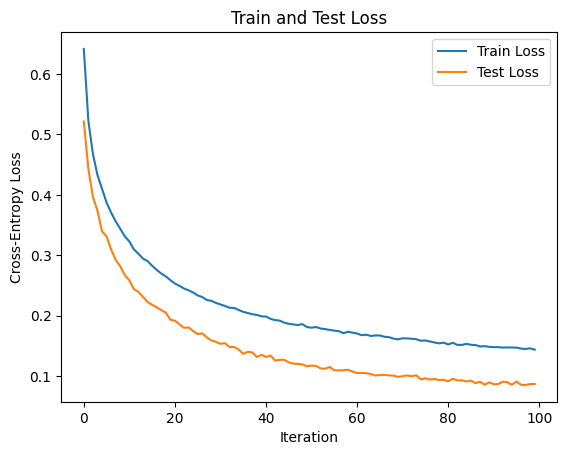

In [16]:
plt.plot(history.index, history['Train Loss'], label="Train Loss")
plt.plot(history.index, history['Test Loss'], label="Test Loss")
plt.title("Train and Test Loss")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.show()

This plot is interesting as the train loss is consistently higher than the test loss. There is, in fact, one key culprit for this: dropout! Since the model is being randomly changed by dropout during training, its average loss is higher as it needs time every epoch to adjust to the configuration. During testing, it's able to use these varied configurations together to achieve a higher confidence on its correct predictions, giving it a lower test loss. Despite this oddity, though, the train and test loss decrease together steadily, indicating a good fit.

Now let's take a look at our final train and test accuracies.

In [17]:
def compute_accuracy(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Computes the accuracy of the model over every training example in the
    DataLoader.

    Parameters:
        model:      The model to be evaluated over the DataLoader
        dataloader: The DataLoader over which the model is to be evaluated

    Returns:
        The accuracy of the model over the dataloader
    """
    model.eval()
    x: torch.Tensor; y: torch.Tensor
    correct_predictions: int = 0
    sm = 0
    with torch.no_grad():
        for _, (x, y) in enumerate(tqdm(dataloader)):
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            out: torch.Tensor = model(x)
            y_pred: torch.Tensor = torch.round(out)
            sm += torch.sum(y_pred)
            correct_predictions += (y_pred == y).sum().item()
    return correct_predictions * 100 / len(dataloader.dataset)

In [18]:
train_accuracy: float = compute_accuracy(model, train_dataloader)
test_accuracy: float = compute_accuracy(model, test_dataloader)
print(
    f'Final Train Accuracy: {train_accuracy}%,',
    f'Final Test Accuracy: {test_accuracy}%'
)

100%|██████████| 313/313 [00:00<00:00, 372.77it/s]

Final Train Accuracy: 98.181%, Final Test Accuracy: 96.645%


Our train and test loss are both pretty strong. They're not very far from each other, indicating that our fit is pretty good. What's more, since we took care to create a balanced dataset, we can be pretty confident that these high accuracy levels represent a classifier that solves the problem in a thorough fashion.